# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

## Шаг 1. Загрузка и изучение данных

### 1.1 Загрузка данных

Загружаем данные из предоставленного CSV-файла в датафрейм с помощью библиотеки Pandas.

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

In [4]:
# Выводим первые 5 строк для ознакомления с данными
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [5]:
# Выводим общую информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Загрузили данные в датафрейм и вывели первые строки и информацию о структуре (типы данных, количество строк, пропуски). Далее построим гистограммы для числовых столбцов, чтобы изучить их распределение.

### 1.2 Построение гистограмм

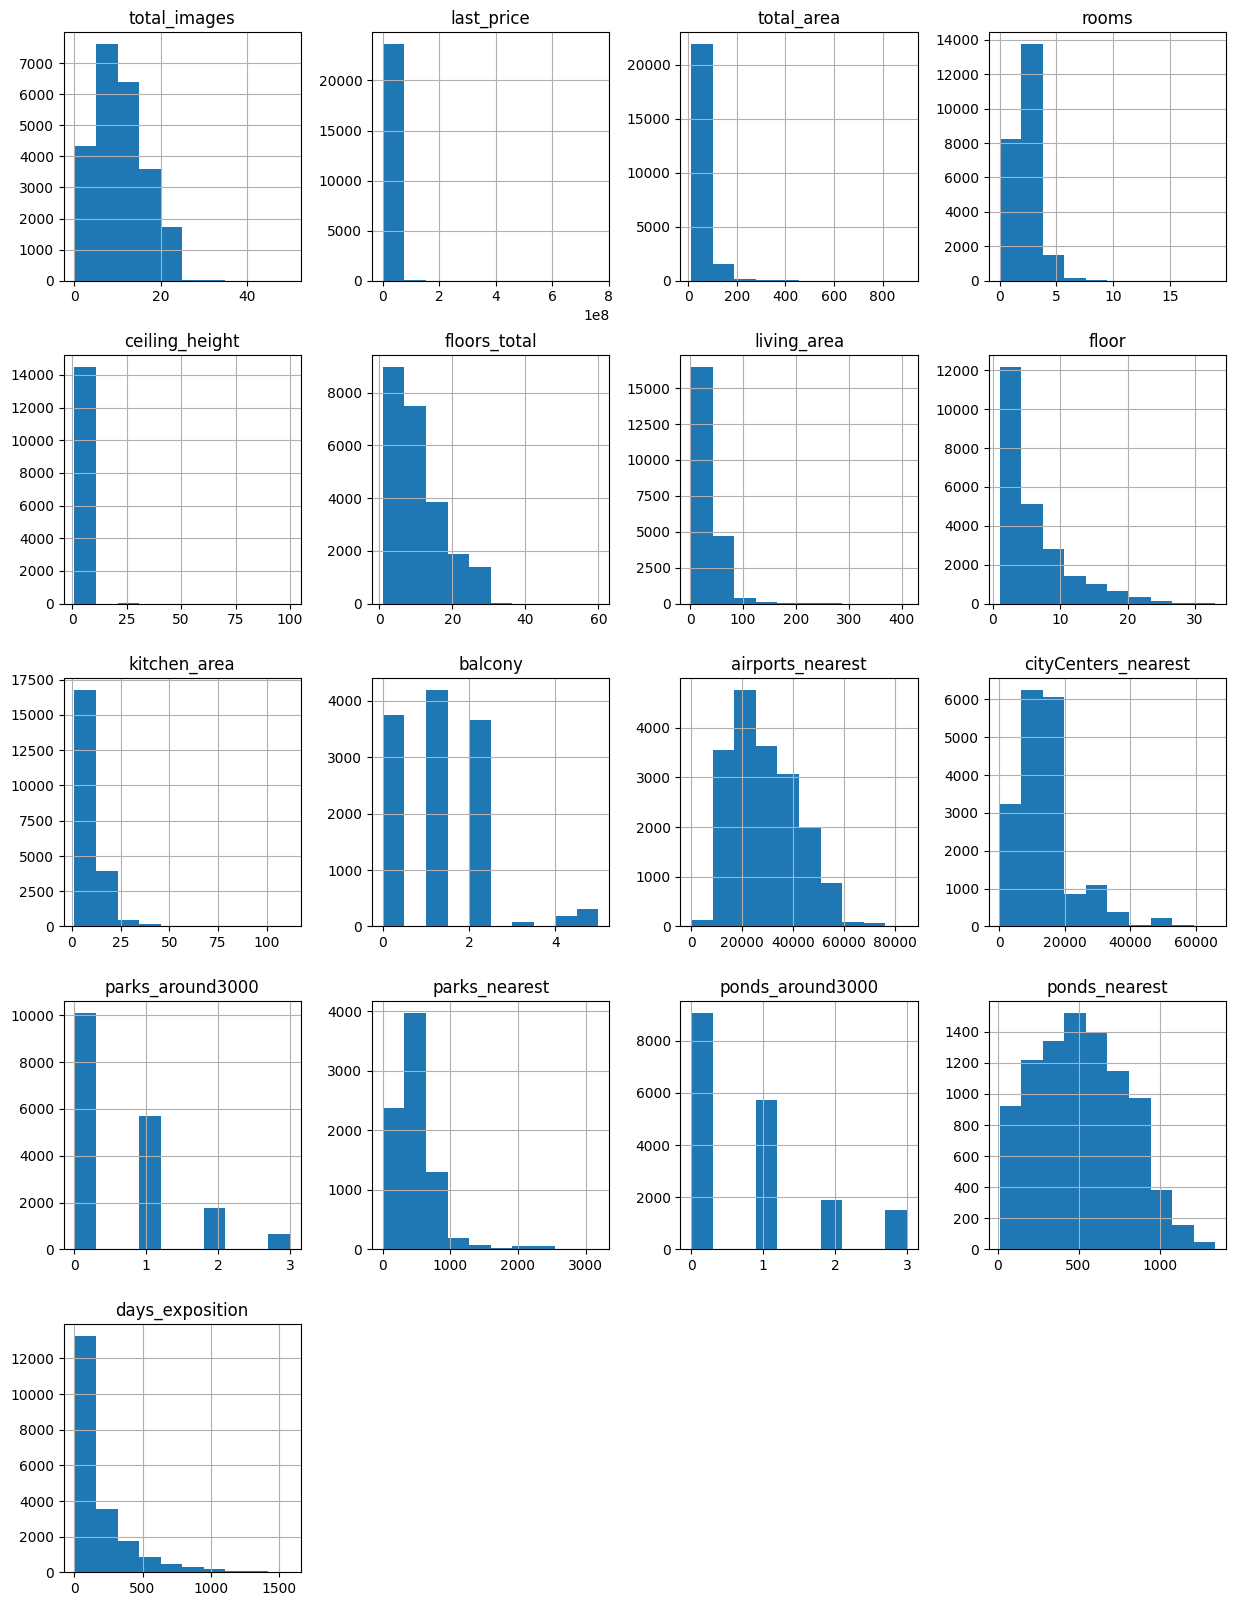

In [6]:
data.hist(figsize=(15, 20));

#### Промежуточный вывод для шага №1

Построили гистограммы для визуального анализа распределения числовых данных. На графиках видны потенциальные аномалии (например, в ceiling_height, last_price), которые требуют обработки. Далее займёмся предобработкой данных: проверим пропуски, исправим типы данных и устраним дубликаты.

## Шаг 2. Предобработка данных

### 2.1 Проверка на количество пропусков и дубликатов

Выведем количество пропусков в каждом столбце и долю от общего датасета

In [7]:
missing_values = data.isna().sum()
missing_percentage = (missing_values / len(data)) * 100
missing_info = pd.DataFrame({'Пропуски': missing_values, 'Доля (%)': missing_percentage})
print(missing_info[missing_info['Пропуски'] > 0])


                     Пропуски   Доля (%)
ceiling_height           9195  38.799105
floors_total               86   0.362885
living_area              1903   8.029875
is_apartment            20924  88.290645
kitchen_area             2278   9.612220
balcony                 11519  48.605426
locality_name              49   0.206760
airports_nearest         5542  23.384953
cityCenters_nearest      5519  23.287902
parks_around3000         5518  23.283683
parks_nearest           15620  65.909954
ponds_around3000         5518  23.283683
ponds_nearest           14589  61.559559
days_exposition          3181  13.422507


Проверка наличия явных дубликатов


In [8]:
print(data.duplicated().unique())

[False]


Проверили наличие явных дубликатов. Результат ```[False]``` указывает, что их нет. Далее обработаем каждый столбец по отдельности, начиная с ```ceiling_height```.

### 2.2 Высота потолков ```(ceiling_height)```

Проверим уникальные значения

In [9]:
print(data['ceiling_height'].unique())

[  2.7     nan   3.03   2.5    2.67   2.56   3.05   2.75   2.6    2.9
   2.8    2.55   3.     2.65   3.2    2.61   3.25   3.45   2.77   2.85
   2.64   2.57   4.15   3.5    3.3    2.71   4.     2.47   2.73   2.84
   3.1    2.34   3.4    3.06   2.72   2.54   2.51   2.78   2.76  25.
   2.58   3.7    2.52   5.2    2.87   2.66   2.59   2.     2.45   3.6
   2.92   3.11   3.13   3.8    3.15   3.55   3.16   3.62   3.12   2.53
   2.74   2.96   2.46   5.3    5.     2.79   2.95   4.06   2.94   3.82
   3.54   3.53   2.83   4.7    2.4    3.38   3.01   5.6    3.65   3.9
   3.18   3.35   2.3    3.57   2.48   2.62   2.82   3.98   2.63   3.83
   3.52   3.95   3.75   2.88   3.67   3.87   3.66   3.85   3.86   4.19
   3.24   4.8    4.5    4.2    3.36  32.     3.08   3.68   3.07   3.37
   3.09   8.     3.26   3.34   2.81   3.44   2.97   3.14   4.37   2.68
   3.22   3.27  27.     4.1    2.93   3.46  24.     3.47   3.33   3.63
   3.32  26.     1.2    8.3    2.98   2.86   3.17   4.4    3.28   3.04
   4.45   5

Исправим аномальные значения высоты потолка

In [10]:
def correct_ceiling_height(height):
    if pd.isna(height):
        return data['ceiling_height'].median()
    if height > 10:
        return height / 10
    if height < 2 or height > 5:
        return data['ceiling_height'].median()
    return height
data['ceiling_height'] = data['ceiling_height'].apply(correct_ceiling_height)

In [11]:
print(data['ceiling_height'].isna().sum())
print(data['ceiling_height'].unique())

0
[ 2.7   2.65  3.03  2.5   2.67  2.56  3.05  2.75  2.6   2.9   2.8   2.55
  3.    3.2   2.61  3.25  3.45  2.77  2.85  2.64  2.57  4.15  3.5   3.3
  2.71  4.    2.47  2.73  2.84  3.1   2.34  3.4   3.06  2.72  2.54  2.51
  2.78  2.76  2.58  3.7   2.52  2.87  2.66  2.59  2.    2.45  3.6   2.92
  3.11  3.13  3.8   3.15  3.55  3.16  3.62  3.12  2.53  2.74  2.96  2.46
  5.    2.79  2.95  4.06  2.94  3.82  3.54  3.53  2.83  4.7   2.4   3.38
  3.01  3.65  3.9   3.18  3.35  2.3   3.57  2.48  2.62  2.82  3.98  2.63
  3.83  3.52  3.95  3.75  2.88  3.67  3.87  3.66  3.85  3.86  4.19  3.24
  4.8   4.5   4.2   3.36  3.08  3.68  3.07  3.37  3.09  3.26  3.34  2.81
  3.44  2.97  3.14  4.37  2.68  3.22  3.27  4.1   2.93  3.46  3.47  3.33
  3.63  3.32  2.98  2.86  3.17  4.4   3.28  3.04  4.45  3.84  3.23  3.02
  3.21  3.43  3.78  4.3   3.39  2.69  3.31  4.65  3.56  2.2   3.51  3.93
  3.42  2.99  3.49  1.4   4.14  2.91  3.88  4.25  3.29  2.25  3.76  3.69
  2.26  2.89  3.58  2.49  4.9   3.48  1.03 10.    

Исправили аномалии в ```ceiling_height``` (значения > 10 м разделили на 10, значения < 2 м или > 5 м заменили медианой) и заполнили пропуски (38.8%) медианой. Пропуски, вероятно, из-за отсутствия данных у продавцов.

Заметим, что после обработки аномалии все не пропали (например, потолок точно не может быть высотой 10 метров). Применим обработку еще раз.

In [12]:
data['ceiling_height'] = data['ceiling_height'].apply(correct_ceiling_height)
print(data['ceiling_height'].unique())

[2.7  2.65 3.03 2.5  2.67 2.56 3.05 2.75 2.6  2.9  2.8  2.55 3.   3.2
 2.61 3.25 3.45 2.77 2.85 2.64 2.57 4.15 3.5  3.3  2.71 4.   2.47 2.73
 2.84 3.1  2.34 3.4  3.06 2.72 2.54 2.51 2.78 2.76 2.58 3.7  2.52 2.87
 2.66 2.59 2.   2.45 3.6  2.92 3.11 3.13 3.8  3.15 3.55 3.16 3.62 3.12
 2.53 2.74 2.96 2.46 5.   2.79 2.95 4.06 2.94 3.82 3.54 3.53 2.83 4.7
 2.4  3.38 3.01 3.65 3.9  3.18 3.35 2.3  3.57 2.48 2.62 2.82 3.98 2.63
 3.83 3.52 3.95 3.75 2.88 3.67 3.87 3.66 3.85 3.86 4.19 3.24 4.8  4.5
 4.2  3.36 3.08 3.68 3.07 3.37 3.09 3.26 3.34 2.81 3.44 2.97 3.14 4.37
 2.68 3.22 3.27 4.1  2.93 3.46 3.47 3.33 3.63 3.32 2.98 2.86 3.17 4.4
 3.28 3.04 4.45 3.84 3.23 3.02 3.21 3.43 3.78 4.3  3.39 2.69 3.31 4.65
 3.56 2.2  3.51 3.93 3.42 2.99 3.49 4.14 2.91 3.88 4.25 3.29 2.25 3.76
 3.69 2.26 2.89 3.58 2.49 4.9  3.48 3.59]


Теперь аномалий и пропущенных значений не осталось. Идем дальше.

#### 2.3 Общее количество этажей ```(floors_total)```

Проверим количество пропусков.

In [13]:
print(data['floors_total'].isna().sum())

86


Количество пропусков 86, что совсем немного для нашей большой выборки. Поэтому, принимаем решение их удалить.

In [14]:
data = data.dropna(subset=['floors_total'])

Приведем данные к целочисленному типу (количество этажей не может быть с плавающей точкой)

In [15]:
data['floors_total'] = data['floors_total'].astype(int)

In [16]:
print(data['floors_total'].dtype)
print(data['floors_total'].isna().sum())

int64
0


Удалили строки с пропусками в floors_total (0.4% данных) и привели к int, так как количество этажей — целые числа. Пропуски скорее всего связаны с ошибками ввода.

#### 2.4. Жилая площадь ```(living_area)```

In [17]:
data['living_area'].isna().sum()

np.int64(1870)

In [18]:
data['living_area'].describe()

,living_area
count,21743.000000
mean,34.462781
std,22.037433
min,2.000000
25%,18.600000
50%,30.000000
75%,42.300000
max,409.700000


Видим, что минимальная площадь - 2 м^2. Посмотрим на датасет

In [19]:
data.sort_values(by='living_area', ascending=True).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
13915,20,6350000.0,52.0,2018-02-06T00:00:00,2,3.00,6,2.0,2,NaN,...,9.0,NaN,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0
21758,0,2330000.0,23.0,2018-01-01T00:00:00,0,2.65,24,2.0,22,NaN,...,NaN,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0
23574,14,64990000.0,139.0,2015-11-24T00:00:00,3,3.00,8,3.0,8,NaN,...,16.0,1.0,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0
3242,7,4440000.0,41.0,2017-07-02T00:00:00,1,2.65,17,3.0,17,NaN,...,11.0,NaN,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0
17582,11,2680000.0,22.0,2018-08-11T00:00:00,0,2.65,25,5.0,8,NaN,...,NaN,2.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,70.0
21943,15,6100000.0,77.6,2019-02-28T00:00:00,4,2.50,9,5.4,1,NaN,...,9.8,NaN,Санкт-Петербург,29338.0,11270.0,1.0,584.0,0.0,NaN,33.0
16431,13,3799000.0,31.0,2018-04-12T00:00:00,1,2.60,5,6.0,1,NaN,...,17.0,NaN,Санкт-Петербург,32177.0,4826.0,1.0,430.0,0.0,NaN,168.0
19251,19,4050000.0,33.0,2018-10-15T00:00:00,1,2.50,22,6.5,21,NaN,...,18.0,NaN,Санкт-Петербург,9258.0,10592.0,1.0,458.0,0.0,NaN,44.0
23208,12,4800000.0,37.0,2016-02-24T00:00:00,1,2.65,14,8.0,11,NaN,...,22.0,0.0,Санкт-Петербург,27838.0,12387.0,2.0,358.0,1.0,950.0,139.0
20994,7,8900000.0,50.6,2018-10-22T00:00:00,2,2.50,7,8.0,3,NaN,...,31.0,NaN,Санкт-Петербург,12771.0,8301.0,1.0,173.0,3.0,126.0,NaN


Рассматривая информацию по квартире с очень маленькой жилплощадью, можно сделать вывод, что это ошибка, и она была допущена при вводе данных. Скорее всего, там 20кв метров, а не 2.
Подобных данных не очень много, а значит они также не повлияют на исследование.

Заполним пропуски

In [20]:
median_living_ratio = (data['living_area'] / data['total_area']).median()
data['living_area'] = data['living_area'].fillna(data['total_area'] * median_living_ratio)
print(data['living_area'].isna().sum())

0


Заполнили пропуски в ```living_area``` медианной пропорцией от ```total_area```, так как жилая площадь коррелирует с общей. Пропуски (около 8%) связаны с невнимательностью продавцов.

### 2.5. Площадь кухни ```(kitchen_area)```

Проверим пропуски

In [21]:
data['kitchen_area'].isna().sum()

np.int64(2231)

In [22]:
data['kitchen_area'].describe()

,kitchen_area
count,21382.000000
mean,10.564128
std,5.904316
min,1.300000
25%,7.000000
50%,9.100000
75%,12.000000
max,112.000000


Ничего странного в данных не обнаружено. Тогда заполним пропуски похожим способом, как в предыдущем пункте.

In [23]:
median_kitchen_ratio = (data['kitchen_area'] / data['total_area']).median()
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area'] * median_kitchen_ratio)
print(data['kitchen_area'].isna().sum())

0


Заполнили пропуски в ```kitchen_area``` (около 9.6%) медианной пропорцией от ```total_area```. Пропуски вызваны невнимательностью или отсутствием данных.

### 2.6 Цена объекта ```(last_price)```

In [24]:
data['last_price'].isna().sum()

np.int64(0)

In [25]:
data['last_price'].describe()

,last_price
count,2.361300e+04
mean,6.540555e+06
std,1.090172e+07
min,1.219000e+04
25%,3.400000e+06
50%,4.650000e+06
75%,6.799000e+06
max,7.630000e+08


In [26]:
print(data.query('last_price < 100000'))

      total_images  last_price  total_area first_day_exposition  rooms  \
8793             7     12190.0       109.0  2019-03-20T00:00:00      2   

      ceiling_height  floors_total  living_area  floor is_apartment  ...  \
8793            2.75            25         32.0     25          NaN  ...   

      kitchen_area  balcony    locality_name  airports_nearest  \
8793          40.5      NaN  Санкт-Петербург           36421.0   

     cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
8793              9176.0               1.0          805.0               0.0   

      ponds_nearest  days_exposition  
8793            NaN              8.0  

[1 rows x 22 columns]


Минимальная цена (12190 руб) выглядит подозрительно, но таких значений мало, и они не сильно повлияют на анализ. Оставим как есть, так как цены реалистичны для рынка.

In [27]:
data.query('last_price == 763_000_000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
12971,19,763000000.0,400.0,2017-09-30T00:00:00,7,2.65,10,250.0,10,NaN,...,68.939075,2.0,Санкт-Петербург,25108.0,3956.0,1.0,530.0,3.0,756.0,33.0


 Параметры квартиры не выглядят странно, она пригодна для изучения.

 Значение хоть и является выбросом, но не сильно повлияет на результаты исследования.

### 2.7 Количество комнат ```(rooms)```

In [28]:
data['rooms'].describe()

,rooms
count,23613.000000
mean,2.071147
std,1.078380
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,19.000000


У квартиры должна быть хотя бы одна комната (даже если это студия), заменим нуля на единицы.

In [29]:
data.loc[data['rooms'] == 0, 'rooms'] = 1

In [30]:
print(data['rooms'].describe())

count    23613.000000
mean         2.079363
std          1.066311
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


Заменили 0 комнат на 1, так как это, вероятно, студии или ошибки ввода. Максимальное значение (19) оставили, так как возможны элитные квартиры.

### 2.8. Балконы (balcony)

In [31]:
print(data['balcony'].isna().sum())

11480


Во многих объявлениях не указано число балконов - вместо этого стоит NaN. Так как балкон достаточно важная часть квартиры, будем считать, что отсутствующие значения == отсутствующий балкон. Заменим подобные значения на 0.

Также приведем данные к типу int64.

In [32]:
data['balcony'] = data['balcony'].fillna(0).astype(int)

data['balcony'].describe()


,balcony
count,23613.000000
mean,0.593063
std,0.960307
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,5.000000


In [33]:
print(data['balcony'].isna().sum())

0



### 2.9 Название населённого пункта ```(locality_name)```

Найдем пропуски в названии населенного пункта

In [34]:
print(data['locality_name'].isna().sum())

48


Поскольку пропусков очень мало по сравнению с нашей выборкой, мы можем их удалить.

In [35]:
data = data.dropna(subset=['locality_name'])

In [36]:
print(data['locality_name'].isna().sum())

0


Удалили строки с пропусками в locality_name (0.2% данных), так как их мало, и они критичны для анализа.

#### 2.10 Формат даты публикации ```first_day_exposition```

Изменим формат даты размещения объявления на корректное значение

In [37]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Привели first_day_exposition к datetime для удобства извлечения дня, месяца, года.

### 2.11. Апартаменты ```(is_apartment)```

In [38]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

Видим NaN, думаем: откуда он мог взяться.

Если квартира не является апартаментами, то данные о ней решили не заполнять, к чему привело большое количество пропусков.

Исправим это:

In [39]:
data['is_apartment'] = data['is_apartment'].fillna(False).astype(bool)

/tmp/ipython-input-1979737392.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['is_apartment'] = data['is_apartment'].fillna(False).astype(bool)


In [40]:
data['open_plan'].unique()

array([False,  True])

Заполнили пропуски в is_apartment (88.3%) значением False, так как апартаменты — редкий тип недвижимости.

### 2.12 Ближайшие аэропорты ```airports_nearest```

In [41]:
print(data['airports_nearest'].isna().sum())

5524


In [42]:
data['airports_nearest'].unique()

array([18863., 12817., 21741., ..., 11751., 20151., 24665.])

Так как заполнить средними или медианными значениями подобные пропуски нельзя, заполним нулями. При проведении исследования такие значения учитываться не будут.

In [43]:
data['airports_nearest'] = data['airports_nearest'].fillna(0)

In [44]:
print(data['airports_nearest'].isna().sum())

0


### 2.13 Ближайшие городские центры ```(cityCenters_nearest)```

In [45]:
data['cityCenters_nearest'].unique()

array([16028., 18603., 13933., ..., 27977.,  7262.,  6263.])

In [46]:
print(data['cityCenters_nearest'].isna().sum())

5501


In [47]:
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(0)

In [48]:
print(data['cityCenters_nearest'].isna().sum())

0


### 2.14 Парки в пределах 3 км ```(parks_around3000)```

In [49]:
data['parks_around3000'].unique()

array([ 1.,  0.,  2., nan,  3.])

In [50]:
print(data['parks_around3000'].isna().sum())

5500


In [51]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)

In [52]:
print(data['parks_around3000'].isna().sum())

0


### 2.15 Ближайшие парки ```(parks_nearest)```

In [53]:
data['parks_nearest'].unique()

array([4.820e+02,       nan, 9.000e+01, 8.400e+01, 1.120e+02, 3.100e+02,
       2.940e+02, 5.900e+02, 4.200e+02, 7.590e+02, 2.480e+02, 5.170e+02,
       4.110e+02, 4.520e+02, 5.320e+02, 4.590e+02, 7.250e+02, 4.700e+01,
       6.200e+02, 6.750e+02, 5.310e+02, 5.260e+02, 2.710e+02, 3.630e+02,
       6.480e+02, 3.820e+02, 3.340e+02, 1.670e+02, 4.450e+02, 2.310e+02,
       5.110e+02, 7.510e+02, 6.660e+02, 3.840e+02, 1.270e+02, 2.410e+02,
       4.880e+02, 1.560e+02, 5.760e+02, 2.850e+02, 6.330e+02, 1.500e+01,
       2.150e+02, 5.330e+02, 1.410e+02, 3.660e+02, 3.410e+02, 5.890e+02,
       3.440e+02, 5.080e+02, 4.170e+02, 7.620e+02, 4.410e+02, 5.590e+02,
       7.490e+02, 5.010e+02, 1.000e+01, 1.133e+03, 1.205e+03, 5.160e+02,
       8.600e+02, 2.760e+02, 9.800e+02, 4.630e+02, 5.910e+02, 2.390e+02,
       6.510e+02, 1.021e+03, 4.850e+02, 5.860e+02, 3.700e+02, 6.880e+02,
       2.750e+02, 5.460e+02, 4.660e+02, 1.390e+02, 2.510e+02, 5.370e+02,
       6.270e+02, 1.040e+02, 4.500e+02, 6.570e+02, 

In [54]:
print(data['parks_nearest'].isna().sum())

15535


In [55]:
data['parks_nearest'] = data['parks_nearest'].fillna(0)

In [56]:
print(data['parks_nearest'].isna().sum())

0


### 2.16 Озера в пределах 3 км ```(ponds_around3000)```

In [57]:
data['ponds_around3000'].unique()

array([ 2.,  0.,  3.,  1., nan])

In [58]:
print(data['ponds_around3000'].isna().sum())

5500


In [59]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

In [60]:
print(data['ponds_around3000'].isna().sum())

0


### 2.17 Ближайшие озера ```(ponds_nearest)```

In [61]:
data['ponds_nearest'].unique()

array([ 755.,   nan,  574., ...,  959.,   40., 1134.])

In [62]:
data['ponds_around3000'].describe()

,ponds_around3000
count,23565.000000
mean,0.589900
std,0.883966
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,3.000000


In [63]:
print(data['ponds_nearest'].isna().sum())

14529


In [64]:
data['ponds_nearest'] = data['ponds_nearest'].fillna(0)

In [65]:
print(data['ponds_nearest'].isna().sum())

0


### 2.18 От публикации до продажи ```(days_exposition)```

In [66]:
data['days_exposition'].unique()

array([  nan,   81.,  558., ..., 1360., 1007.,  971.])

In [67]:
data['days_exposition'].isna().sum()

np.int64(3171)

Более 10% объявлений из архива не имеют значения в этом столбце. Такой столбец заполнялся автоматически, а значит возможных причин две: ошибка при загрузке или обработке данных и более простой - квартира так и не была продана на момент создания датасета.

In [68]:
data['days_exposition'] = data['days_exposition'].fillna(0)

In [69]:
data['days_exposition'].isna().sum()

np.int64(0)

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony              

Как видно, мы убрали все пропуски. Но нам осталось проверить пропуски на неявные дубликаты.

### 2.19 Устранение неявных дубликатов в ```locality_name```

In [71]:
print(data['locality_name'].unique())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

In [72]:
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['поселок городского типа ', 'поселок ', 'деревня ', 'село ', 'садовое товарищество ', 'городской поселок '], '', regex=True)
)

In [73]:
print(data['locality_name'].nunique())
print(data['locality_name'].unique())

317
['Санкт-Петербург' 'Шушары' 'городской Янино-1' 'Парголово' 'Мурино'
 'Ломоносов' 'Сертолово' 'Петергоф' 'Пушкин' 'Кудрово' 'Коммунар'
 'Колпино' 'Красный Бор' 'Гатчина' 'Федоровское' 'Выборг' 'Кронштадт'
 'Кировск' 'Новое Девяткино' 'Металлострой' 'Лебяжье' 'Сиверский'
 'Молодцово' 'Кузьмоловский' 'Новая Ропша' 'Павловск' 'Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк' 'Куттузи'
 'Аннино' 'Ефимовский' 'Плодовое' 'Заклинье' 'Торковичи' 'Первомайское'
 'Красное Село' 'Понтонный' 'Сясьстрой' 'Старая' 'Лесколово' 'Новый Свет'
 'Сланцы' 'Путилово' 'Ивангород' 'Шлиссельбург' 'Никольское' 'Зеленогорск'
 'Сосновый Бор' 'Оржицы' 'Кальтино' 'Романовка' 'Бугры' 'Рощино' 'Кириши'
 'Луга' 'Волосово' 'Отрадное' 'Павлово' 'Оредеж' 'Копорье' 'Молодежное'
 'Тихвин' 'Победа' 'Нурма' 'Синявино' 'Тосно' 'Стрельна' 'Бокситогорск'
 'Александровская' 'Лопухинка' 'Пикалево' 'Терволово' 'Советский'
 'Подпорожье' 'Петровское' 'Токсово' 'Сельцо' 'Вырица' 'Кипень' 'Келози'
 'Вартемяги

Устранили неявные дубликаты в ```locality_name```, заменив «ё» на «е» и убрав уточнения, такие как «посёлок» или «деревня», т.к. нам не понадобится информация о типе населенного пункта

#### Промежуточный вывод для шага №2

- Проверили отсутствие явных дубликатов.
- Обработали каждый столбец: заполнили пропуски (нули, медианы, пропорции), исправили аномалии, привели типы данных к логичным.
- Пропуски в геоданных заполнили нулями, чтобы не искажать анализ.
- Устранили неявные дубликаты в locality_name

## Шаг 3. Добавим в таблицу новые столбцы

#### Цена одного квадратного метра

In [74]:
# Цена за квадратный метр
data['price_per_sqm'] = (data['last_price'] / data['total_area']).round(2)

In [75]:
#день, месяц и год публикации объявления
data['day_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year

In [76]:
# Тип этажа
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'
data['floor_type'] = data.apply(floor_type, axis=1)

In [77]:
#переводим метры в км
def distance_to_the_center(distance):
    return round(distance / 1000)

data['distance_to_the_center'] = data['cityCenters_nearest'].apply(distance_to_the_center)

In [78]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sqm,day_exposition,month_exposition,year_exposition,floor_type,distance_to_the_center
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,482.0,2.0,755.0,0.0,120370.37,3,3,2019,другой,16
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.600000,1,False,...,0.0,0.0,0.0,81.0,82920.79,1,12,2018,первый,19
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.300000,4,False,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,90.340909,9,False,...,84.0,3.0,234.0,424.0,408176.10,4,7,2015,другой,7
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8


#### Промежуточный вывод для шага №3

В данном разделе были написаны функции `price_of_a_metre` (цена метра в данной квартире), `type_of_floor` (тип этажа) и `distance_to_the_center` (расстояние до центра). Созданы новые столбцы путем применения этих методов к уже существуеющим столбцам. В дальнейшем это поможет при исследовательском анализе.

## Шаг 4. Исследовательский анализ данных

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23565 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23565 non-null  int64         
 1   last_price              23565 non-null  float64       
 2   total_area              23565 non-null  float64       
 3   first_day_exposition    23565 non-null  datetime64[ns]
 4   rooms                   23565 non-null  int64         
 5   ceiling_height          23565 non-null  float64       
 6   floors_total            23565 non-null  int64         
 7   living_area             23565 non-null  float64       
 8   floor                   23565 non-null  int64         
 9   is_apartment            23565 non-null  bool          
 10  studio                  23565 non-null  bool          
 11  open_plan               23565 non-null  bool          
 12  kitchen_area            23565 non-null  float64    

Изучим некоторые параметры объектов и построим отдельные гистограммы для каждого из этих параметров.

### 4.1 Общая площадь ```total_area```

Посмотрим, как распределяется количество объявлений в зависимости от общей площади квартиры:

Построим гистограмму, исключив очень большие значения при помощи параметра `range`.

Ограничим диапазон до 99-го перцентиля для наглядности

In [80]:
data = data[data['total_area'] <= data['total_area'].quantile(0.999)]

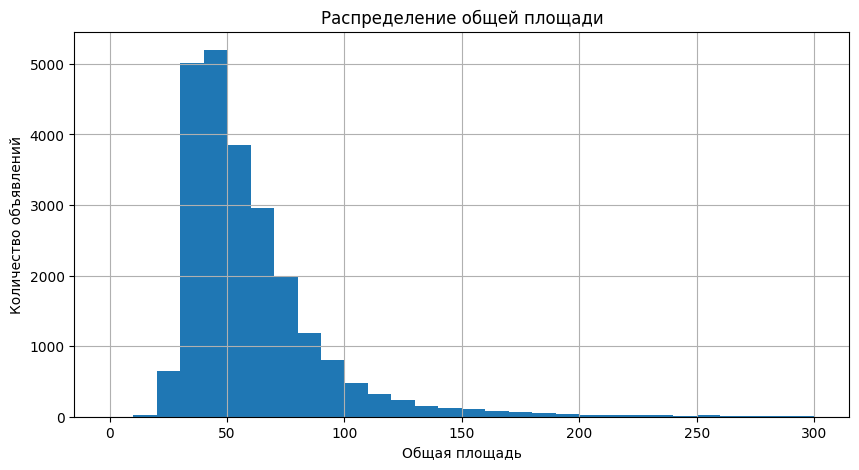

In [81]:
import matplotlib.pyplot as plt

area_hist = data['total_area'].hist(bins=30, range=(0, 300), figsize=(10, 5))
area_hist.set_title('Распределение общей площади')
area_hist.set_xlabel('Общая площадь')
area_hist.set_ylabel('Количество объявлений')

plt.show()

Распределение с явным смещением влево. Достаточно внушительная часть квартир (более 10 тысяч) имеют площадь менее 50 квадратных метров. Приблизительно такое же количество квартир имеют площадь от 50 до 100 кв м.

Проверим это предположение, взглянув на квартили распределения:

In [82]:
data['total_area'].describe()

,total_area
count,23542.000000
mean,59.884817
std,32.630491
min,12.000000
25%,40.000000
50%,52.000000
75%,69.582500
max,400.000000


##### Промежуточный вывод

Исходя из изученных данных, можно сделать вывод о том, что основная масса (около половины) проданных квартир в Санкт-Петербурге и его окрестностях имеют площадь порядка 50 кв м. Четверть всех значений (от 50% до 75%) лежат между 52 и 70 квадратами.
Подавляющее большинство продаваемых квартир имеют площадь менее 70 кв м.

### 4.2 Жилая площадь ```living_area```

Построим гистограмму, аналогично с прошлым пунктом и удалим выбросы.

In [83]:
data = data[data['living_area'] <= data['living_area'].quantile(0.999)]

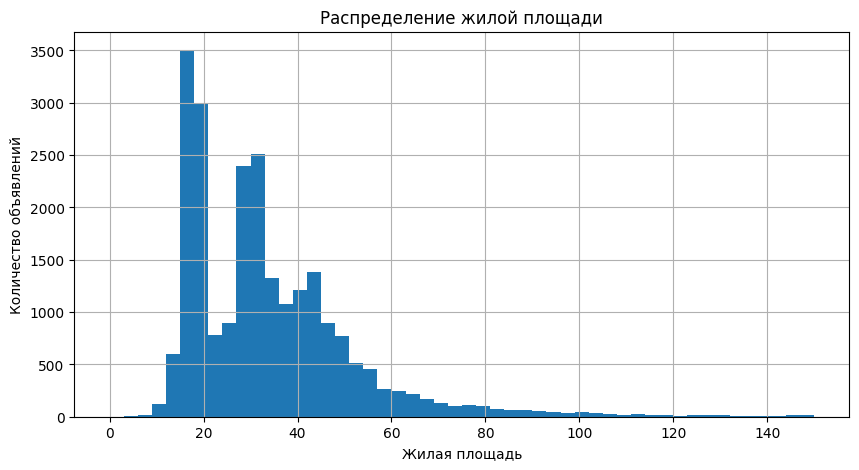

In [84]:
living_area_hist = data['living_area'].hist(bins=50, range=(0, 150), figsize=(10, 5))
living_area_hist.set_title('Распределение жилой площади')
living_area_hist.set_xlabel('Жилая площадь')
living_area_hist.set_ylabel('Количество объявлений')

plt.show()

In [85]:
data['living_area'].describe()

,living_area
count,23518.000000
mean,34.138800
std,19.951128
min,2.000000
25%,19.000000
50%,30.000000
75%,42.000000
max,198.000000


##### Промежуточный вывод

Явных закономерностей в распределении не имеется, зато имеются несколько (на первый взгял) выбросов. На отметках приблизительно 20 и 28 квадратных метров имеются два пика. С чем это может быть связано? Скорее всего, это стандартный размер жилплощади для типовых квартир. Очевидно, что таких квартир действительно большое количество, а значит и число типовых значений тоже будет велико.

### 4.3 Площадь кухни ```kitchen_area```

In [86]:
data = data[data['kitchen_area'] <= data['kitchen_area'].quantile(0.999)]

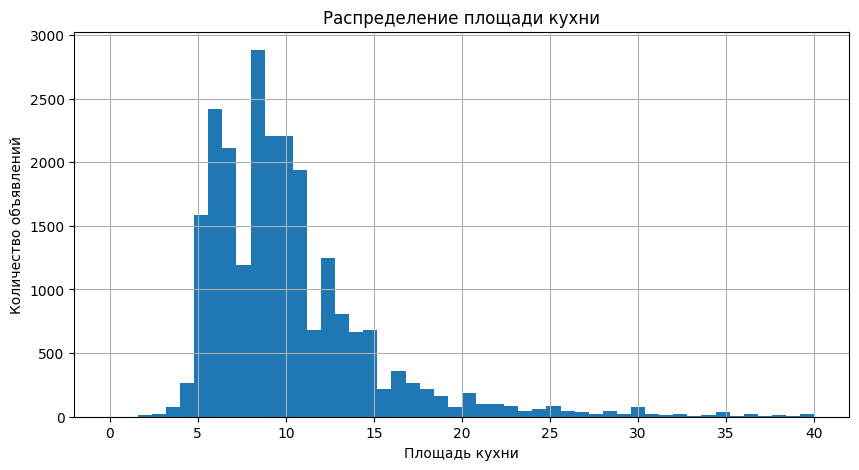

In [87]:
kitchen_area_hist = data['kitchen_area'].hist(bins=50, range=(0, 40), figsize=(10, 5))
kitchen_area_hist.set_title('Распределение площади кухни')
kitchen_area_hist.set_xlabel('Площадь кухни')
kitchen_area_hist.set_ylabel('Количество объявлений')

plt.show()

In [88]:
data['kitchen_area'].describe()

,kitchen_area
count,23494.000000
mean,10.351837
std,5.364057
min,1.300000
25%,7.000000
50%,9.000000
75%,12.000000
max,58.000000


##### Промежуточный вывод

Снова видны пики - 6, 8 метров и небольшой на 13. Причина та же - это стандартные размеры подобных помещений в типовых квартирах.

### 4.4 Цена объекта ```last_price```



In [89]:
data['last_price'].describe()

,last_price
count,2.349400e+04
mean,6.276938e+06
std,7.619658e+06
min,1.219000e+04
25%,3.400000e+06
50%,4.600000e+06
75%,6.750000e+06
max,3.300000e+08


Удалим выбросы

In [90]:
data = data[data['last_price'] <= data['last_price'].quantile(0.999)]

###### До 10 млн

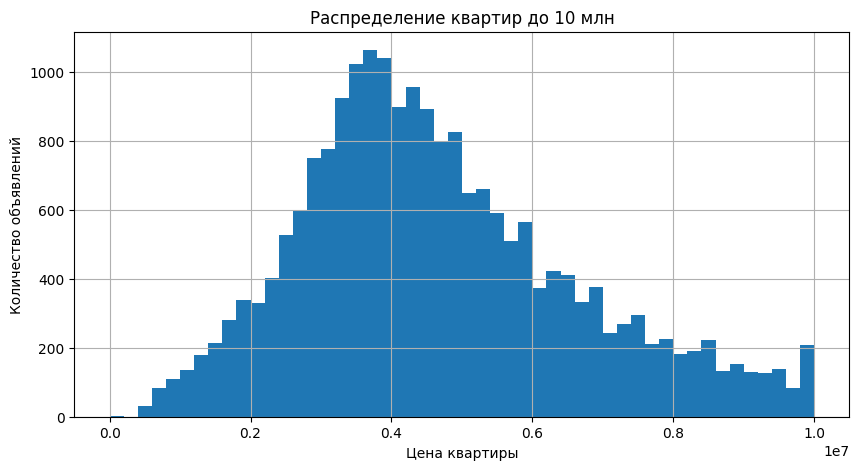

In [91]:
last_price_hist = data['last_price'].hist(bins=50, range=(0, 10_000_000), figsize=(10, 5))
last_price_hist.set_title('Распределение квартир до 10 млн')
last_price_hist.set_xlabel('Цена квартиры')
last_price_hist.set_ylabel('Количество объявлений')

plt.show()

Распределение цен на квартиры в пределах 10 млн напоминает нормальное.

Квартир, стоимостью менее 4 млн рублей практически 9 тысяч:

In [92]:
len(data.query('last_price < 4_000_000'))

8797

И практически 12000 квартир располагаются в ценовом диапазоне от 4 до 10 млн:

In [93]:
len(data.query('last_price > 4_000_000 and last_price < 10_000_000'))

11748

###### От 10 до 30 млн

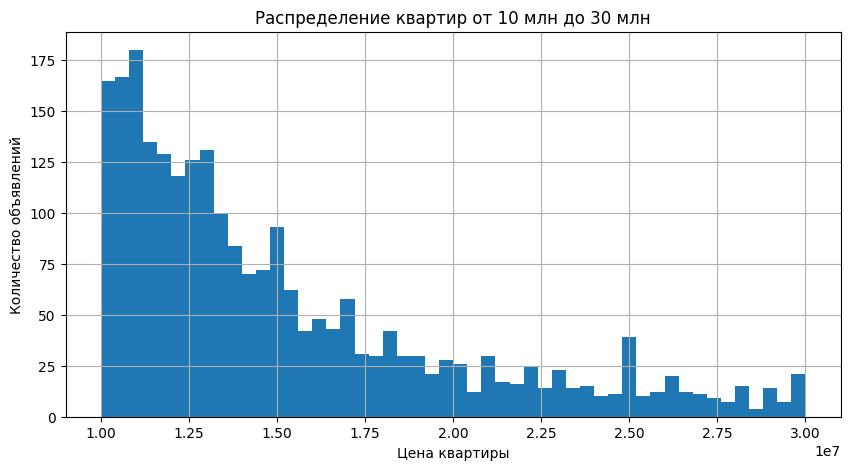

In [94]:
last_price_hist = data['last_price'].hist(bins=50, range=(10_000_000, 30_000_000), figsize=(10, 5))
last_price_hist.set_title('Распределение квартир от 10 млн до 30 млн')
last_price_hist.set_xlabel('Цена квартиры')
last_price_hist.set_ylabel('Количество объявлений')

plt.show()

Более дорогих квартир уже сильно меньше:

In [95]:
len(data.query('10_000_000 <= last_price <= 30_000_000'))

2429

###### От 30 до 100 млн

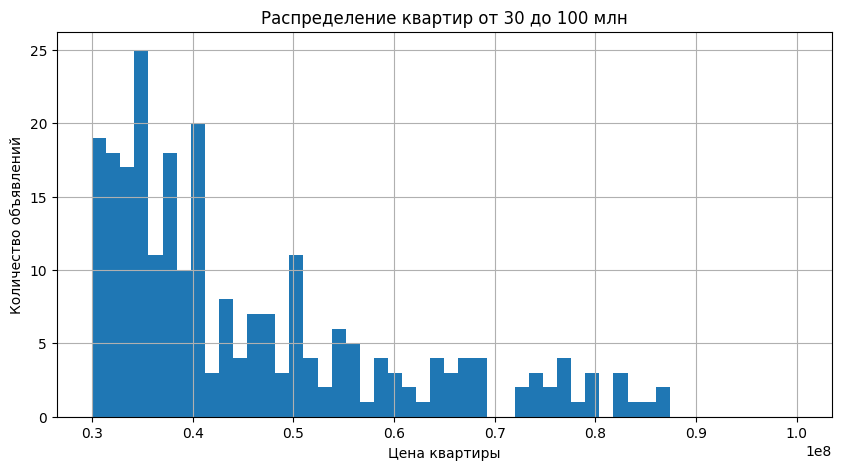

In [96]:
last_price_hist = data['last_price'].hist(bins=50, range=(30_000_000, 100_000_000), figsize=(10, 5))
last_price_hist.set_title('Распределение квартир от 30 до 100 млн')
last_price_hist.set_xlabel('Цена квартиры')
last_price_hist.set_ylabel('Количество объявлений')

plt.show()

In [97]:
len(data.query('30_000_000 <= last_price <= 100_000_000'))

246

Поскольку мы удалили выбросы, то квартиры после 75 миллионов не отображаются на гистограмме.

###### От 100 до 800 млн

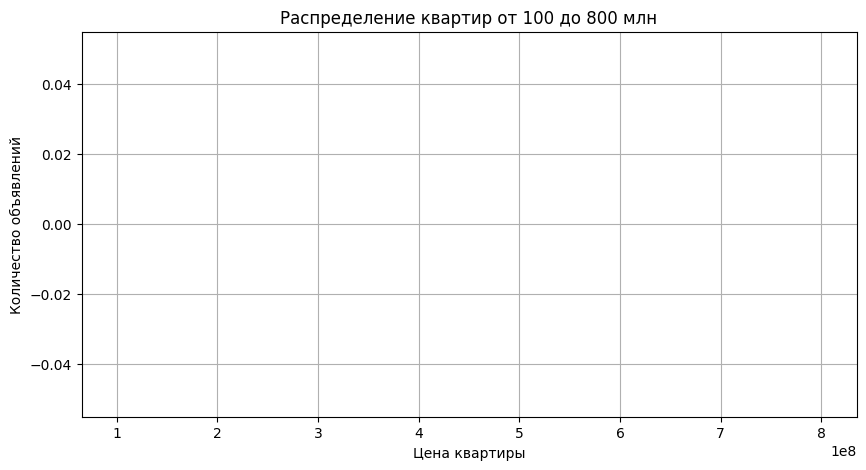

In [98]:
last_price_hist = data['last_price'].hist(bins=50, range=(100_000_000, 800_000_000), figsize=(10, 5))
last_price_hist.set_title('Распределение квартир от 100 до 800 млн')
last_price_hist.set_xlabel('Цена квартиры')
last_price_hist.set_ylabel('Количество объявлений')

plt.show()

In [99]:
len(data.query('100_000_000 <= last_price <= 800_000_000'))

0

А здесь же гистограмма пустая, т.к. все квартиры со стоимостью от 100 до 800 млн являлись выбросами.

##### Промежуточный вывод

- Более 20000 объявлений расположены в диапазоне до 10 млн - свыше 87% всех объявлений.
- От 10 до 30 млн - 2436 квартир, чуть больше 10%.
- От 30 до 100 млн значений уже совсем мало: 239, что совсем немногим больше 1%.
- Более 100 млн - 0 квартир.

Сразу можно сказать, что основное исследование будет проводиться на данных, цена квартир в которых менее 30 млн рублей, так как это около 97% значений. Более крупные числа на исследования не повлияют, их слишком мало.

### 4.5 Количество комнат ```rooms```

In [100]:
data = data[data['rooms'] <= data['rooms'].quantile(0.999)]

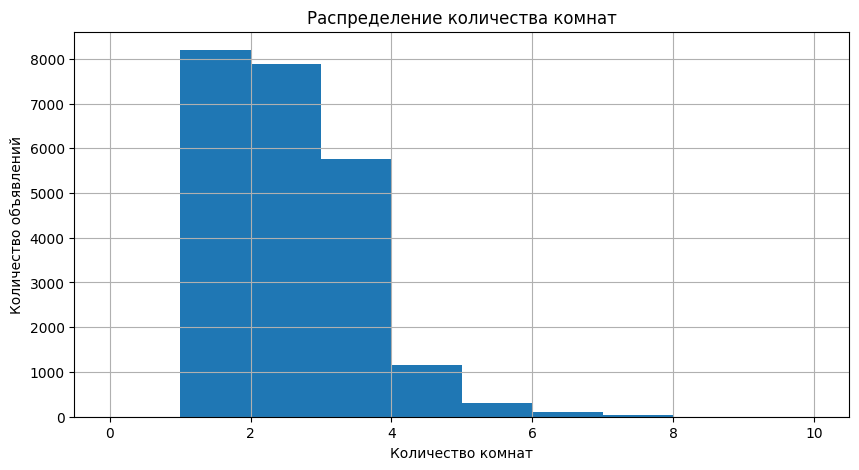

In [101]:
rooms_hist = data['rooms'].hist(bins=10, range=(0, 10), figsize=(10, 5))
rooms_hist.set_title('Распределение количества комнат')
rooms_hist.set_xlabel('Количество комнат')
rooms_hist.set_ylabel('Количество объявлений')

plt.show()

In [102]:
len(data.query('rooms <= 4'))

23006

In [103]:
data['rooms'].describe()

,rooms
count,23448.000000
mean,2.058939
std,1.007723
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,7.000000


##### Промежуточный вывод

Более 97% всех квартир имеют 4 и менее комнат, исследование будет строиться именно на них. \
Имеются большие значение, но при построении диаграммы они не учитывались для наглядности. Они не будут учитываться при исследовании.

Также, исходя из графика очевидно, что преобладают однокомнатные квартиры. Но стоит отметить, что такой результат получился в том числе из-за того, что мы убрали квартиры с 0 комнат, заменив их на однушки. Скорее всего, нулькомнатные квартиры являются однокомнатыми, поэтому мы можем так сделать.

### 4.6 Высота потолков ```ceiling_height```

In [104]:
data = data[data['ceiling_height'] <= data['ceiling_height'].quantile(0.999)]

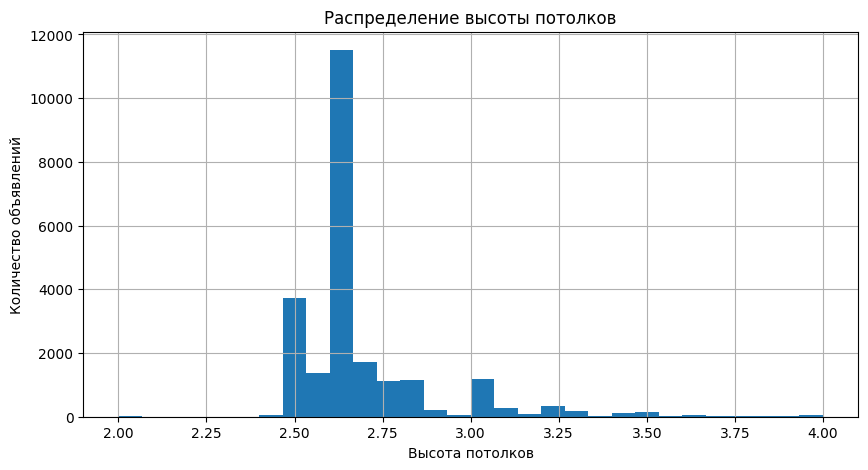

In [105]:
ceil_hist = data['ceiling_height'].hist(bins=30,range=(2, 4), figsize=(10, 5))
ceil_hist.set_title('Распределение высоты потолков')
ceil_hist.set_xlabel('Высота потолков')
ceil_hist.set_ylabel('Количество объявлений')

plt.show()

##### Промежуточный вывод

Закономерности в распределении отсутствуют, но снова есть шипы. \
2.50, 2.65 и 3.00 метра - вот самые распространенные значения. \
И снова причина та же - типовая застройка и стандартные значения для потолков.

In [106]:
data['ceiling_height'].describe()

,ceiling_height
count,23431.000000
mean,2.692492
std,0.205275
min,2.000000
25%,2.600000
50%,2.650000
75%,2.700000
max,4.200000


### 4.7 Тип этажа квартиры ```type_of_floor```

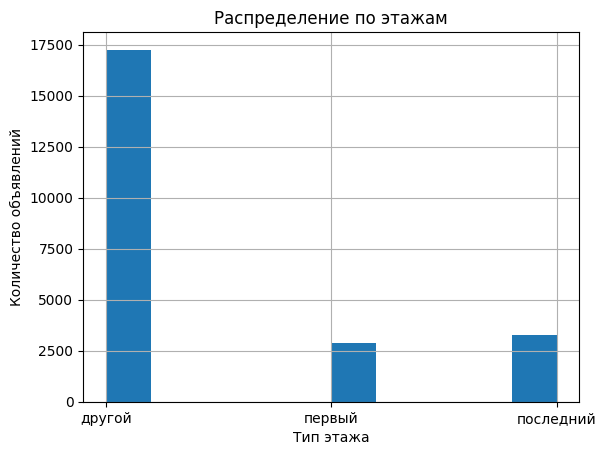

In [107]:
floor_hist = data['floor_type'].hist()
floor_hist.set_title('Распределение по этажам')
floor_hist.set_xlabel('Тип этажа')
floor_hist.set_ylabel('Количество объявлений')

plt.show()

Приблизительно равное количество квартир находятся на первом и последнем этажах - их одинаково мало.

In [108]:
len(data.query('floor_type == "другой"'))

17247

In [109]:
len(data.query('floor_type == "первый"'))

2899

In [110]:
len(data.query('floor_type == "последний"'))

3285

### 4.8 Общее количество этажей в доме ```floors_total```

In [111]:
data = data[data['floors_total'] <= data['floors_total'].quantile(0.999)]

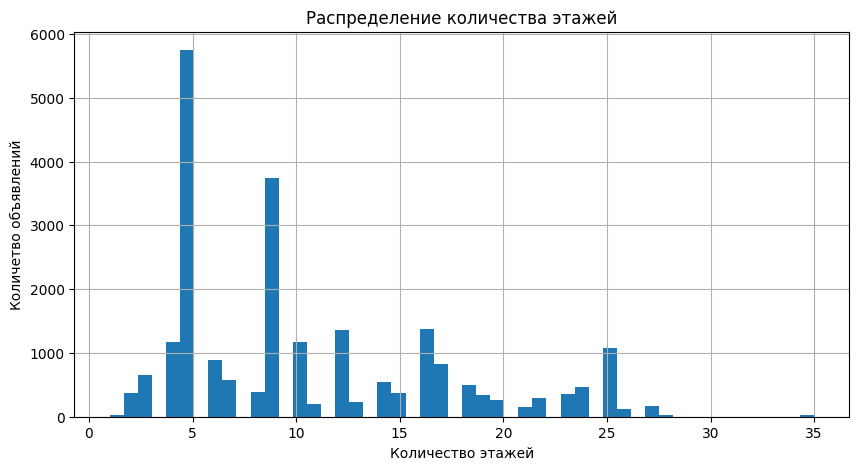

In [112]:
floors_hist = data['floors_total'].hist(bins=50, figsize=(10, 5))
floors_hist.set_title('Распределение количества этажей')
floors_hist.set_xlabel('Количество этажей')
floors_hist.set_ylabel('Количетво объявлений')

plt.show()

In [113]:
len(data.query('floors_total == 5'))

5748

In [115]:
len(data.query('floors_total == 9'))

3750

In [116]:
data['floors_total'].describe()

,floors_total
count,23425.000000
mean,10.691441
std,6.578614
min,1.000000
25%,5.000000
50%,9.000000
75%,16.000000
max,35.000000


##### Промежуточный вывод

5 и 9 этажей - это классическое количество этажей для домов в любом городе. Собственно, это мы и видим - почти 10 тысяч значений именно такие. \
В остальных случаях закономерностей нет.

### 4.9 Расстояние до центра города в метрах ```cityCenters_nearest```

In [117]:
data = data[data['cityCenters_nearest'] <= data['cityCenters_nearest'].quantile(0.999)]

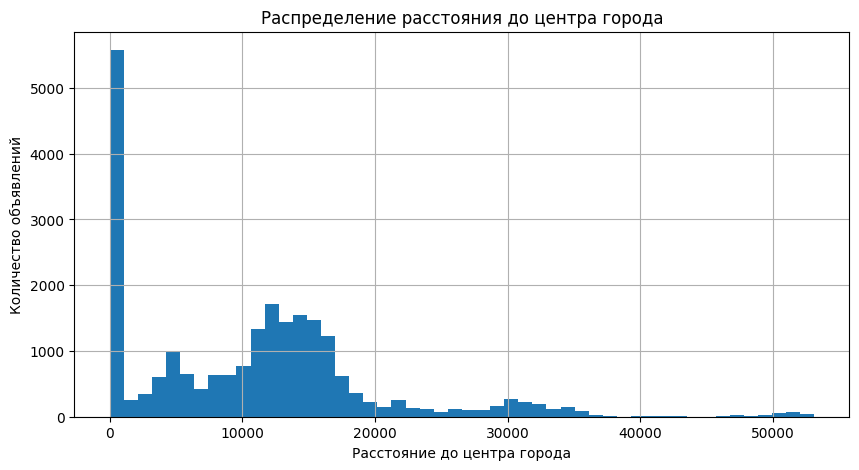

In [118]:
center_hist = data['cityCenters_nearest'].hist(bins=50, figsize=(10, 5))
center_hist.set_title('Распределение расстояния до центра города')
center_hist.set_xlabel('Расстояние до центра города')
center_hist.set_ylabel('Количество объявлений')

plt.show()

In [119]:
data['cityCenters_nearest'].describe()

,cityCenters_nearest
count,23401.000000
mean,10855.346951
std,9530.435431
min,0.000000
25%,2164.000000
50%,11273.000000
75%,15234.000000
max,53104.000000


##### Промежуточный вывод

Большинство квартир (75%) находятся на расстоянии до ~16 км, а 99% — до ~30 км.

### 4.10 Расстояние до ближайшего парка ```parks_nearest```

In [120]:
data = data[data['parks_nearest'] <= data['parks_nearest'].quantile(0.999)]

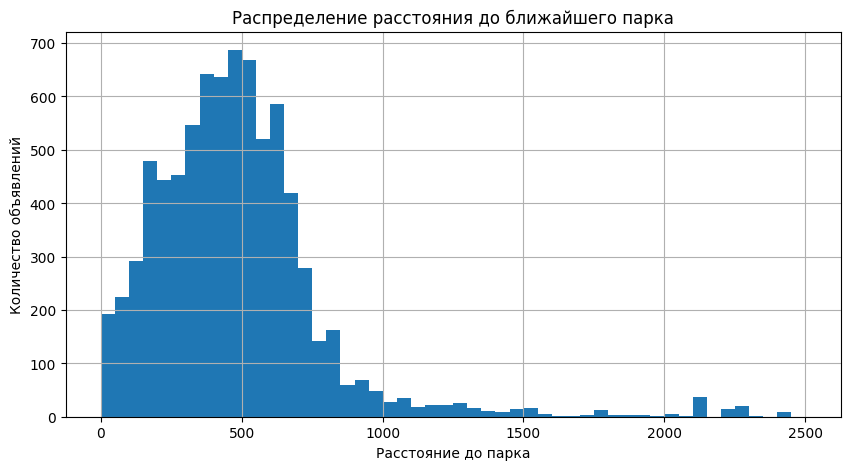

In [121]:
parks_hist = data['parks_nearest'].hist(bins=50, range=(1, 2500), figsize=(10, 5))
parks_hist.set_title('Распределение расстояния до ближайшего парка')
parks_hist.set_xlabel('Расстояние до парка')
parks_hist.set_ylabel('Количество объявлений')

plt.show()

Так как во время предобработки данных мы заменили NaN на 0, исключаем их из гистограммы при помощи параметра `range`.

Как мы можем заметить, в целом значений очень мало. Это значит, что в достаточно серьезной части объявлений продавцы либо не указали имеющиеся в окрестности парки, либо их нет.

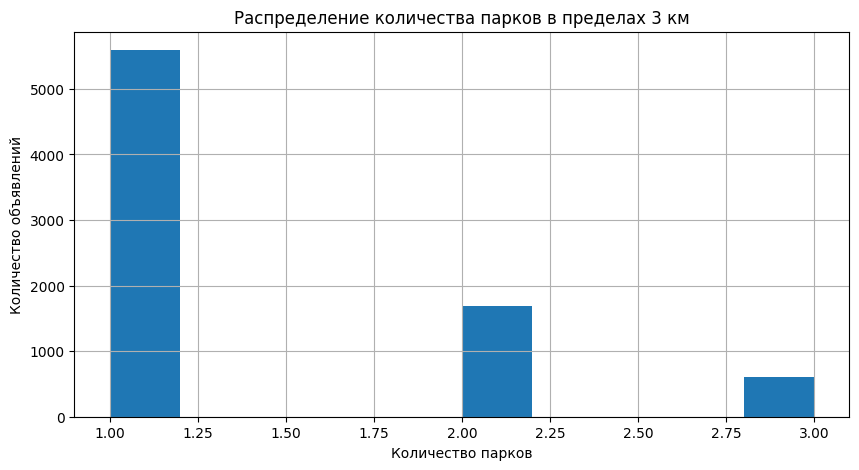

In [122]:
parks_around_hist = data['parks_around3000'].hist(range=(1, 3), figsize=(10, 5))
parks_around_hist.set_title('Распределение количества парков в пределах 3 км')
parks_around_hist.set_xlabel('Количество парков')
parks_around_hist.set_ylabel('Количество объявлений')

plt.show()

Фактически, это та же самая гистограмма, но построенная на данных о количестве парков в радиусе 3км от квартиры.

### 4.11 Как быстро продавались квартиры?

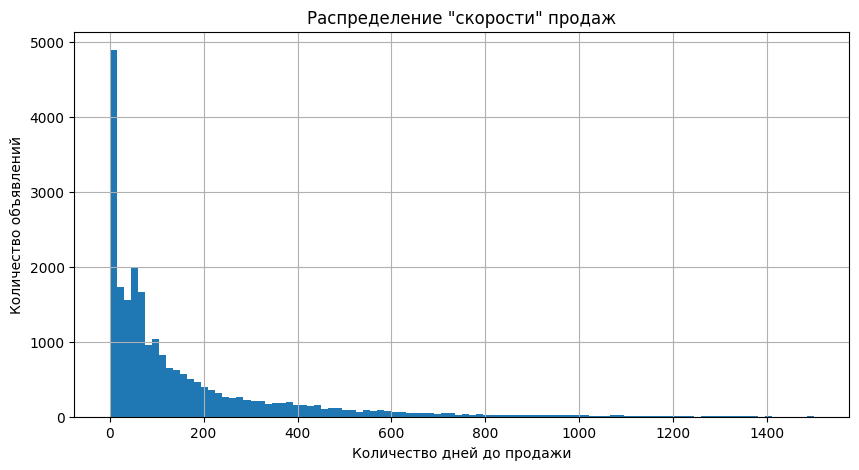

In [123]:
days_hist = data['days_exposition'].hist(bins=100, range=(0, 1500), figsize=(10, 5))
days_hist.set_title('Распределение "скорости" продаж')
days_hist.set_xlabel('Количество дней до продажи')
days_hist.set_ylabel('Количество объявлений')

plt.show()

In [124]:
mean_days = data[data['days_exposition'] > 0]['days_exposition'].mean()
median_days = data[data['days_exposition'] > 0]['days_exposition'].median()
print(f'Среднее время продажи: {mean_days:.1f} дней')
print(f'Медиана времени продажи: {median_days:.1f} дней')

Среднее время продажи: 179.9 дней
Медиана времени продажи: 95.0 дней


In [125]:
data['days_exposition'].describe()

,days_exposition
count,23377.000000
mean,155.800573
std,212.542959
min,0.000000
25%,22.000000
50%,73.000000
75%,197.000000
max,1580.000000


Среднее - ровно полгода.
А вот с медианой интереснее - 95 дней, то есть 3 месяца. Это в два раза меньше среднего.
С чем это связано? У нас есть несколько очень больших значений (несколько лет), которые очень сильно искажают данные.

Поэтому, ответом на вопрос "Как быстро продаются квартиры?", можно ответить, что скорость продажи 3-4 месяца.

Какие продажи можно считать быстрыми, а какие — долгими?

Наиболее логичным вариантом при таком разбросе будет смотреть на квартили распределения. Необычно быстрыми будем считать те объявления, в которых значение `days_exposition` меньше значения первого квартиля - 22 дня. Слишком долгими будем считать такие, в которых значение > 197 дней.

Сколько обычно занимает продажа: около 95 дней.
Быстрые продажи: менее 95 дней.
Необычно долгие продажи: более 197 дней.

In [126]:
len(data.query('days_exposition < 22'))

5736

In [127]:
len(data.query('days_exposition > 197'))

5835

### 4.11 Зависит ли цена от общей площади?

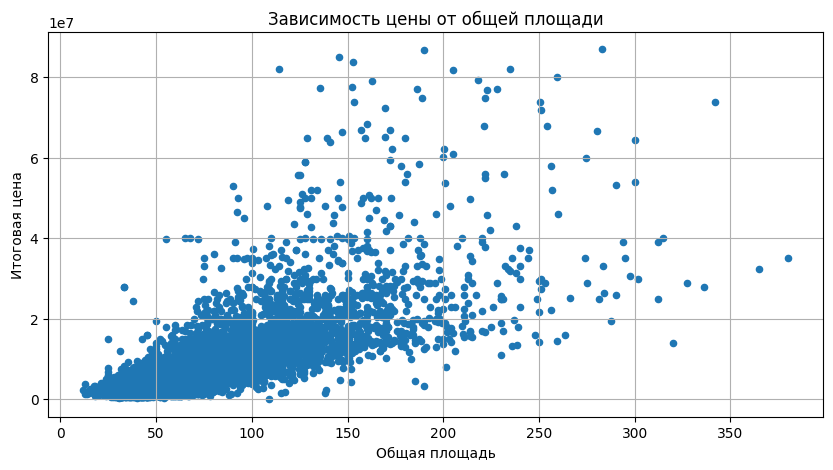

In [133]:
total_area_plot = data.sort_values('total_area').plot(x='total_area', y='last_price', kind='scatter',
                                     figsize=(10, 5), grid=True)
total_area_plot.set_title('Зависимость цены от общей площади')
total_area_plot.set_xlabel('Общая площадь')
total_area_plot.set_ylabel('Итоговая цена')

plt.show()

In [129]:
data['total_area'].corr(data['last_price'])

np.float64(0.7561187225098932)

Цена растёт с увеличением площади, что логично, так как большие квартиры дороже.

Да, цена зависит от общей площади объекта, причем достаточно сильно.

### 4.12 Зависит ли цена от жилой площади?

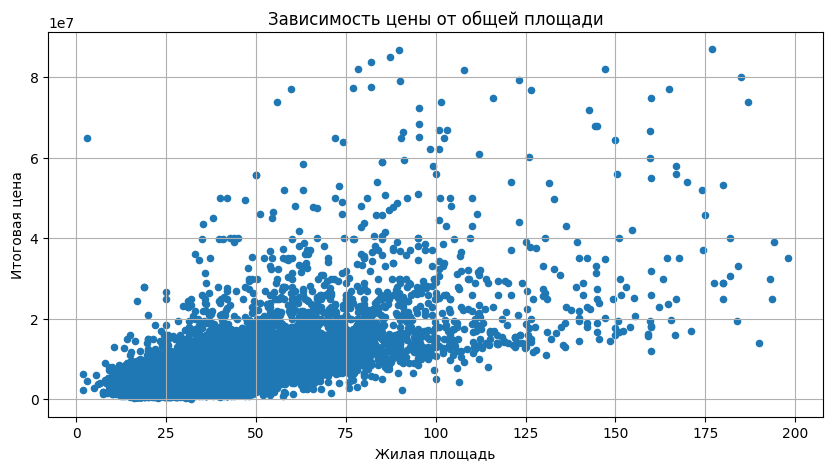

In [130]:
living_area_plot = data.sort_values('living_area').plot(x='living_area', y='last_price',
                                     figsize=(10, 5), grid=True)
living_area_plot.set_title('Зависимость цены от общей площади')
living_area_plot.set_xlabel('Жилая площадь')
living_area_plot.set_ylabel('Итоговая цена')

plt.show()

In [131]:
data['living_area'].corr(data['last_price'])

np.float64(0.66900662860217)

Жилая площадь влияет на цену, но менее сильно, чем общая, так как включает только комнаты.

Тем не менее, и график, и значение корреляции, равное ~ 0.67, говорит о сильной зависимости этих двух величин.

### 4.13 Зависит ли цена от площади кухни?

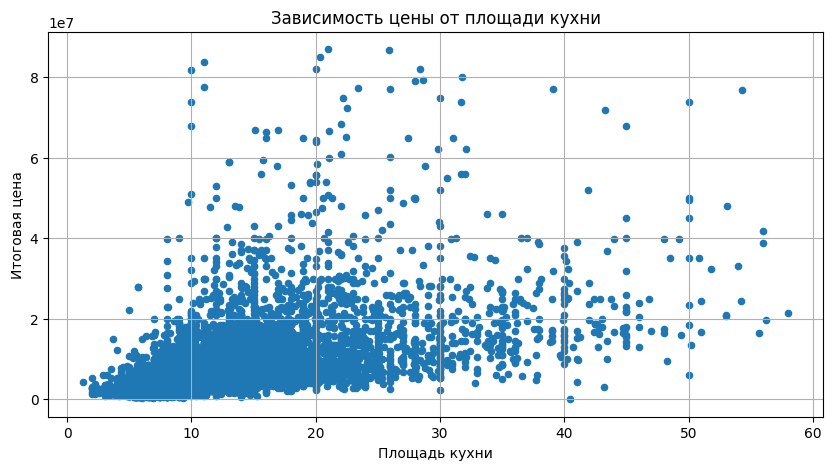

In [135]:
kitchen_area_plot = data.sort_values('kitchen_area').plot(x='kitchen_area', y='last_price', kind='scatter',
                                     figsize=(10, 5), grid=True)
kitchen_area_plot.set_title('Зависимость цены от площади кухни')
kitchen_area_plot.set_xlabel('Площадь кухни')
kitchen_area_plot.set_ylabel('Итоговая цена')

plt.show()

In [136]:
data['kitchen_area'].corr(data['last_price'])

np.float64(0.5835046111257567)

Корреляция ~0.52, умеренная зависимость. Большие кухни увеличивают цену, но влияние слабее, даже чем у жилой площади.

Тем не менее, сделать вывод о том, что площадь кухни в квартире (как и любая площадь в квартире) влияет на ее цену.

### 4.14 Зависит ли цена от количества комнат?

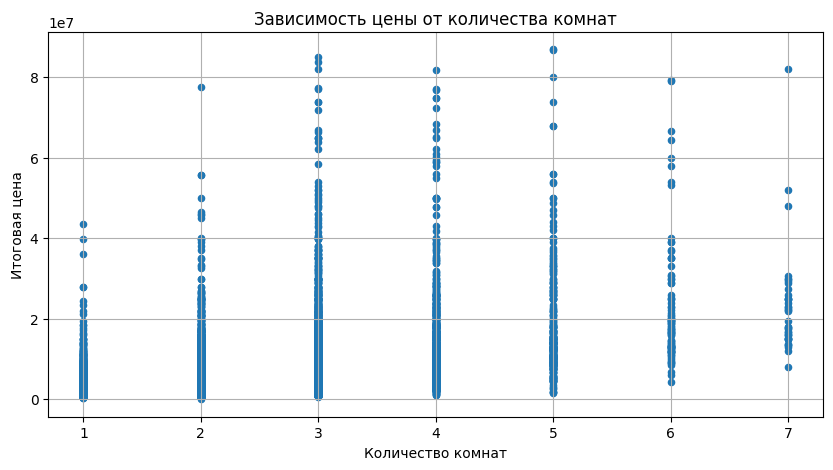

In [141]:
rooms_plot = data.sort_values('rooms').plot(x='rooms', y='last_price', kind='scatter',
                                     figsize=(10, 5), grid=True)
rooms_plot.set_title('Зависимость цены от количества комнат')
rooms_plot.set_xlabel('Количество комнат')
rooms_plot.set_ylabel('Итоговая цена')

plt.show()

In [138]:
data['rooms'].corr(data['last_price'])

np.float64(0.46656024629613196)

Слабая зависимость. Цена растёт до 4–5 комнат, но для больших значений зависимость менее выражена, так как элитные квартиры имеют сложное ценообразование.

### 4.15 Зависит ли цена от этажа?

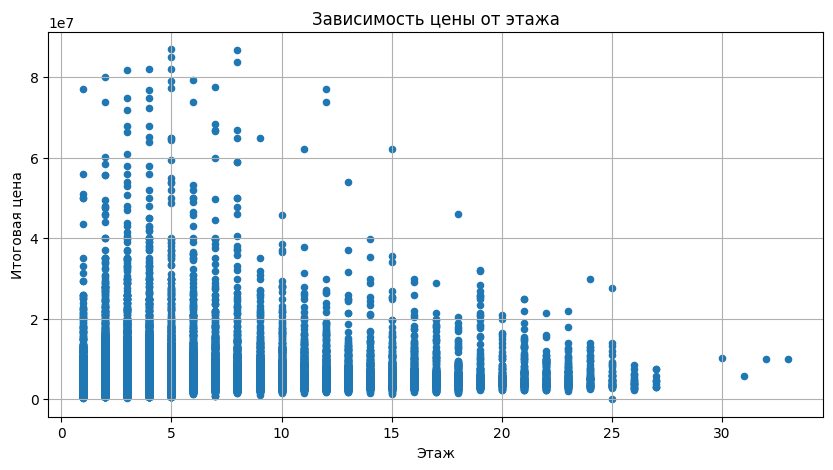

In [145]:
floor_plot = data.sort_values('floor').plot(x='floor', y='last_price', kind='scatter',
                                     figsize=(10, 5), grid=True)
floor_plot.set_title('Зависимость цены от этажа')
floor_plot.set_xlabel('Этаж')
floor_plot.set_ylabel('Итоговая цена')

plt.show()

In [147]:
data['floor'].corr(data['last_price'])

np.float64(0.04408462797998923)

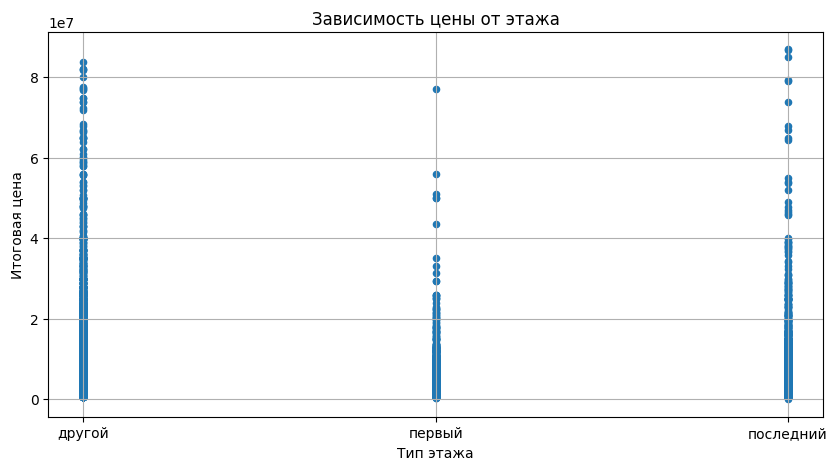

In [146]:
type_floor_plot = data.sort_values('floor_type').plot(x='floor_type', y='last_price', kind='scatter',
                                     figsize=(10, 5), grid=True)
type_floor_plot.set_title('Зависимость цены от этажа')
type_floor_plot.set_xlabel('Тип этажа')
type_floor_plot.set_ylabel('Итоговая цена')

plt.show()

Зависимость отсутствует.

Квартиры на «других» этажах имеют более высокую медианную цену, чем на первом или последнем. Первый этаж обычно дешевле из-за шума и меньшей приватности.

### 4.16 Зависит ли цена от даты размещения?

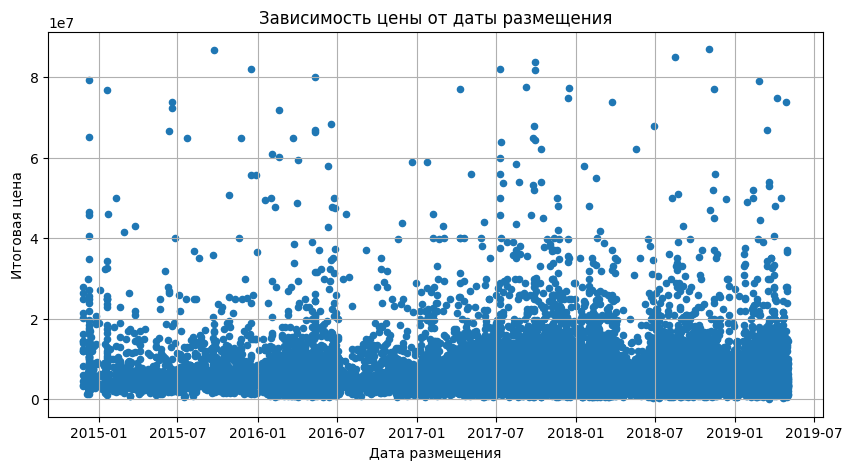

In [154]:
first_day_plot = data.plot(x='first_day_exposition', y='last_price', kind='scatter',
                                     figsize=(10, 5), grid=True)
first_day_plot.set_title('Зависимость цены от даты размещения')
first_day_plot.set_xlabel('Дата размещения')
first_day_plot.set_ylabel('Итоговая цена')

plt.show()

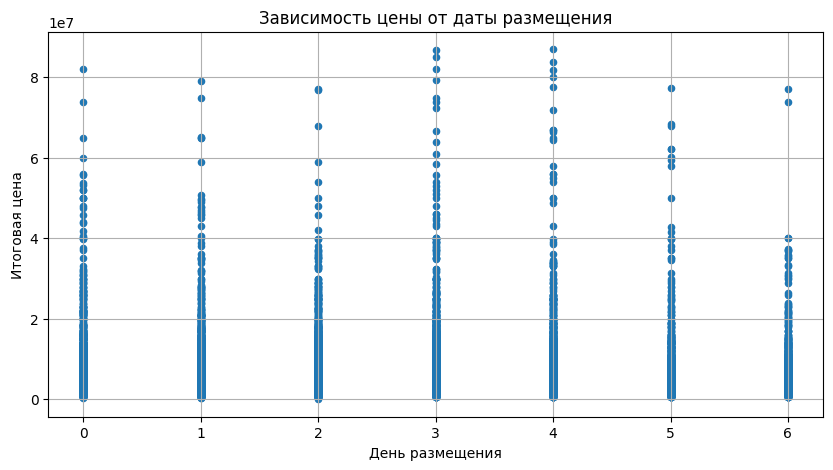

In [150]:
day_plot = data.plot(x='day_exposition', y='last_price', kind='scatter',
                                     figsize=(10, 5), grid=True)
day_plot.set_title('Зависимость цены от даты размещения')
day_plot.set_xlabel('День размещения')
day_plot.set_ylabel('Итоговая цена')

plt.show()

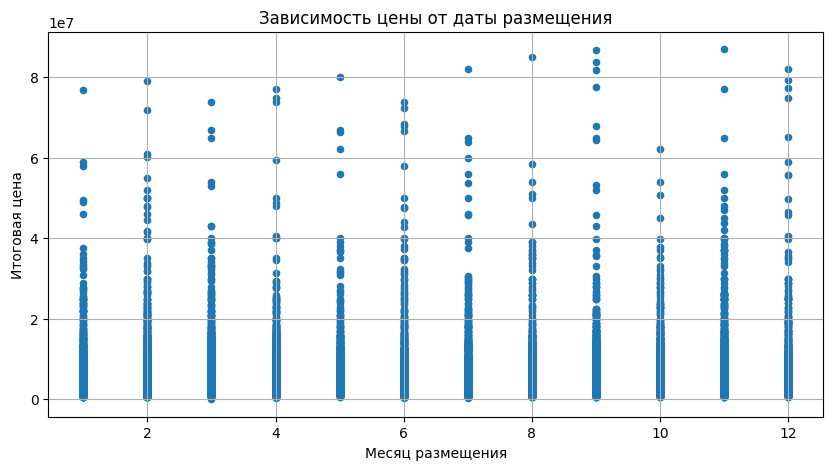

In [151]:
month_plot = data.plot(x='month_exposition', y='last_price', kind='scatter',
                                     figsize=(10, 5), grid=True)
month_plot.set_title('Зависимость цены от даты размещения')
month_plot.set_xlabel('Месяц размещения')
month_plot.set_ylabel('Итоговая цена')

plt.show()

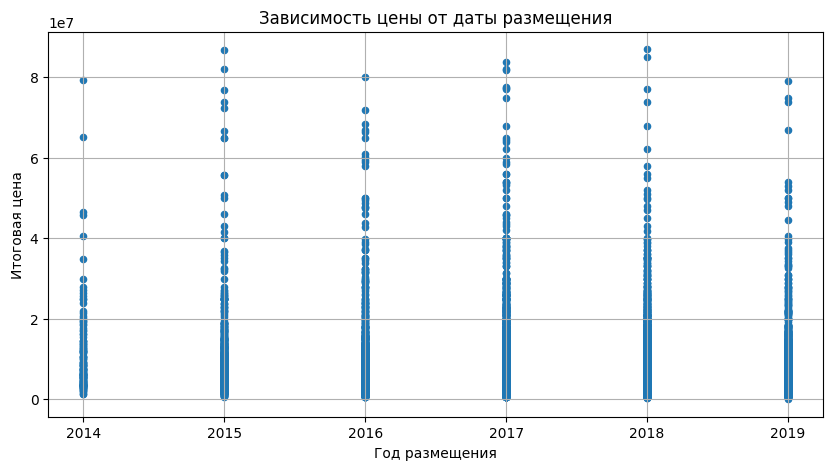

In [152]:
year_plot = data.plot(x='year_exposition', y='last_price', kind='scatter',
                                     figsize=(10, 5), grid=True)
year_plot.set_title('Зависимость цены от даты размещения')
year_plot.set_xlabel('Год размещения')
year_plot.set_ylabel('Итоговая цена')

plt.show()

Никаких закономерностей в том, в какой день/месяц/год было размещено объявление. Следовательно, дата размещения не является фактором, влияющим на цену квартиры.


### 4.17 Средняя цена квадратного метра

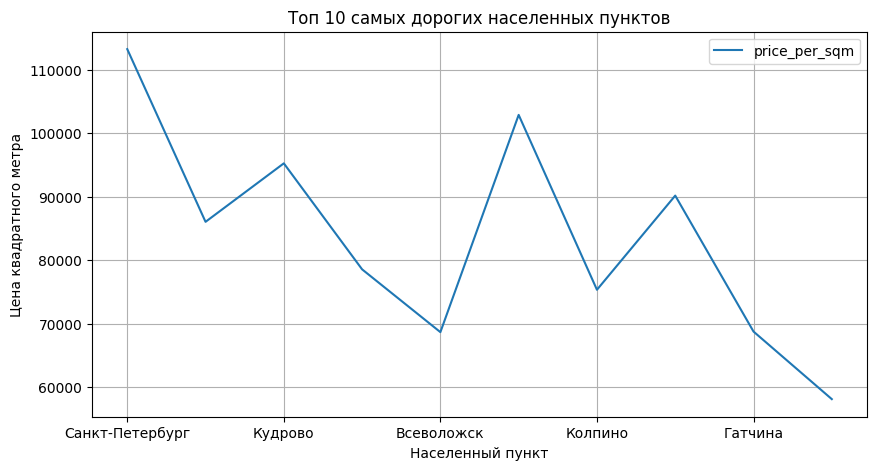

In [168]:
metre_price = data.pivot_table(index='locality_name', values='price_per_sqm',
                 aggfunc=['count', 'mean'])

metre_price.columns = ['count', 'price_per_sqm']
#сохраняем в переменную top_10 топ-10 городов с наибольшим количеством объявлений и строим график
top_10 = metre_price.sort_values(by='count', ascending=False).head(10)
top_10_plot = top_10.plot(y='price_per_sqm', kind='line', figsize=(10, 5), grid=True)
top_10_plot.set_title('Топ 10 самых дорогих населенных пунктов')
top_10_plot.set_xlabel('Населенный пункт')
top_10_plot.set_ylabel('Цена квадратного метра')
plt.show()

Text(0, 0.5, 'Цена квадратного метра')

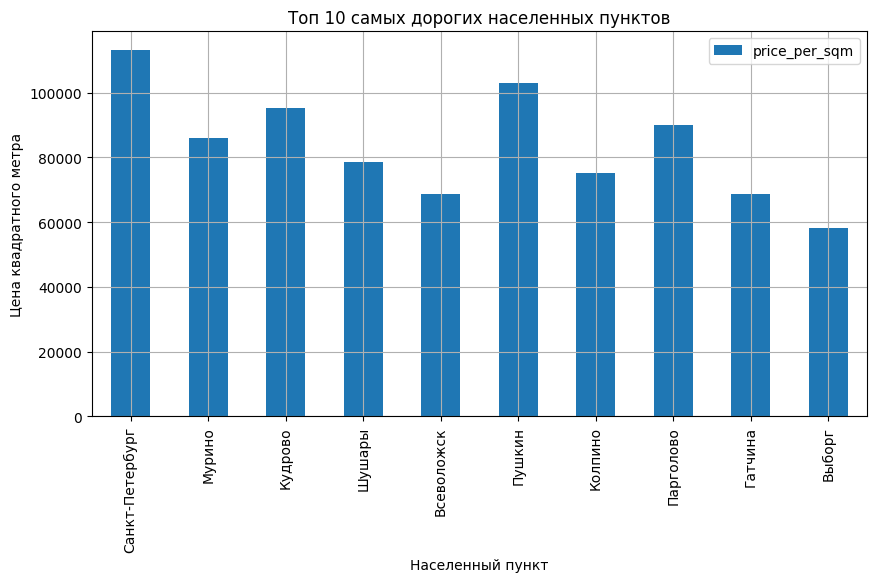

In [176]:
top_10_plot = top_10.plot(y='price_per_sqm', kind='bar', figsize=(10, 5), grid=True)
top_10_plot.set_title('Топ 10 самых дорогих населенных пунктов')
top_10_plot.set_xlabel('Населенный пункт')
top_10_plot.set_ylabel('Цена квадратного метра')

In [165]:
top_10

,count,price_per_sqm
locality_name,,
Санкт-Петербург,15496,113266.216025
Мурино,586,86041.116024
Кудрово,470,95260.846128
Шушары,439,78551.344647
Всеволожск,398,68654.473970
Пушкин,365,102900.024767
Колпино,337,75333.295816
Парголово,327,90175.913089
Гатчина,307,68746.146515


Очевидно, что в Санкт-Петербурге наибольшее число объявлений, а средняя цена квадратного метра там - около 113 тысяч.

In [169]:
top_10.sort_values(by='price_per_sqm')

,count,price_per_sqm
locality_name,,
Выборг,236,58093.893347
Всеволожск,398,68654.473970
Гатчина,307,68746.146515
Колпино,337,75333.295816
Шушары,439,78551.344647
Мурино,586,86041.116024
Парголово,327,90175.913089
Кудрово,470,95260.846128
Пушкин,365,102900.024767


Среди населенных пунктов с самым большим количеством объявлений самый девешый квадратный метр в Выборге - всего 58 тысяч.

In [171]:
metre_price.sort_values('price_per_sqm').head(10)

,count,price_per_sqm
locality_name,,
Старополье,3,11206.220
станции Свирь,2,11481.480
Вахнова Кара,1,11688.310
Выскатка,2,12335.480
Совхозный,2,12629.130
Малая Романовка,1,12724.550
Тесово-4,1,12931.030
Сижно,1,13709.680
Ям-Тесово,2,13711.555


А вот среди всех населенных пунктов из датасета, наименьшую цену квадратного метра имеет некое Старополье: чуть больше 11000 рублей.

### 4.18 Какова цена мили?

Фильтруем данные по Санкт-Петербургу

In [172]:
data_spb = data[data['locality_name'] == 'Санкт-Петербург']

data_spb_distance = data_spb.pivot_table(index='distance_to_the_center', values='last_price', aggfunc='mean')
data_spb_distance.columns = ['avg_price']
data_spb_distance

,avg_price
distance_to_the_center,
0,1.595410e+07
1,1.442904e+07
2,1.416356e+07
3,1.074004e+07
4,1.125124e+07
5,1.205022e+07
6,1.272476e+07
7,1.373511e+07
8,9.067410e+06


Text(0, 0.5, 'Стоимость жилья')

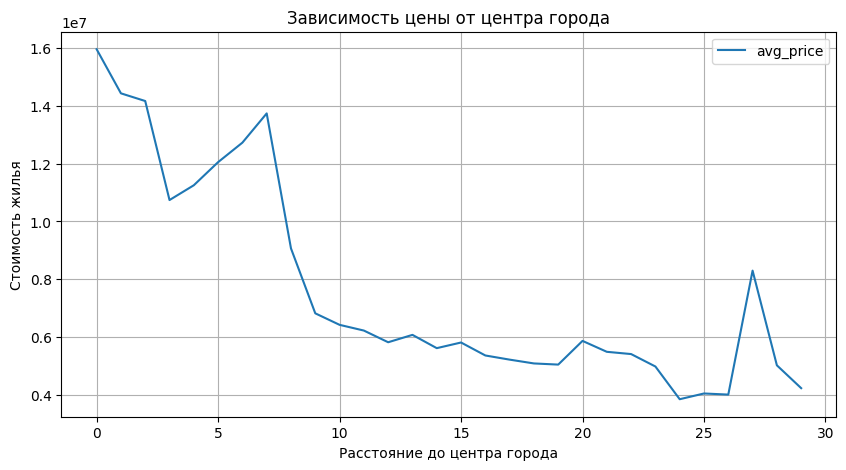

In [178]:
ax = data_spb_distance.plot(kind='line', figsize=(10, 5), grid=True)
ax.set_title('Зависимость цены от центра города')
ax.set_xlabel('Расстояние до центра города')
ax.set_ylabel('Стоимость жилья')

Text(0, 0.5, 'Стоимость жилья')

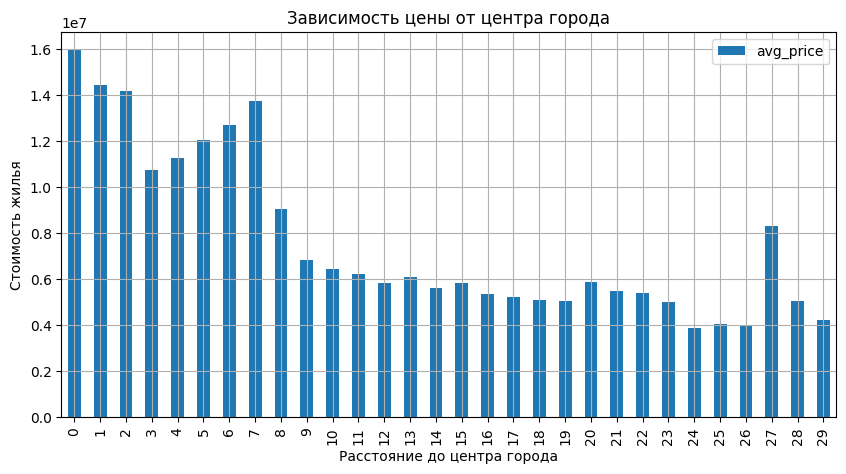

In [179]:
ax = data_spb_distance.plot(kind='bar', figsize=(10, 5), grid=True)
ax.set_title('Зависимость цены от центра города')
ax.set_xlabel('Расстояние до центра города')
ax.set_ylabel('Стоимость жилья')

Как и ожидалось, самые дорогие квартиры в центре города и рядом с ним.
На первом километре заметно резкое снижение - с 14 млн до 10.5 млн.
После следует небольшой подъем до 14 миллионов на седьмом километре от центра, а после 9-го цена уже не сильно зависит от приближенности к центру города.

Также наблюдается выброс на 27 км от центра города. Скорее всего очередной выброс.

In [180]:
data_spb.query('distance_to_the_center == 27')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sqm,day_exposition,month_exposition,year_exposition,floor_type,distance_to_the_center
748,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,False,...,1496.0,0.0,0.0,128.0,193918.92,1,11,2017,другой,27
5961,6,2250000.0,32.0,2018-02-27,1,2.65,2,16.5,2,False,...,0.0,0.0,0.0,178.0,70312.50,1,2,2018,последний,27


Ничего необычного, всего лишь главная проблема среднего - выбросы. Тут одна квартира продается за 14.5 млн, а вторая всего за 2.25 миллиона. Среднее у них около 8, что и дает нам такой пик на графике.

На данном этапе исследования были рассмотрены ключевые параметры, влияющие на стоимость недвижимости. В ходе работы были построены и проанализированы распределения для основных характеристик объектов, таких как общая и жилая площадь, этаж, а также дата публикации объявления.

**Основные выводы:**

- Наибольшее влияние на цену оказывают:

1) Общая площадь квартиры — чем больше, тем выше стоимость.
2) Жилая площадь — напрямую коррелирует с итоговой ценой.
3) Площадь кухни — также значимый фактор.
4) Количество комнат — актуально для квартир с числом комнат до 5.

- Несущественные факторы:
Дата размещения объявления не демонстрирует заметного влияния на стоимость.

- Особенности этажей:
Квартиры на первом этаже, как правило, стоят дешевле, чем на других.

- Географический анализ:
Были выявлены населенные пункты с самой высокой и низкой стоимостью квадратного метра. Лидером по цене ожидаемо стал Санкт-Петербург, где недвижимость в целом дороже, чем в других регионах.

- Зависимость от удаленности от центра:
В Санкт-Петербурге прослеживается чёткая тенденция: чем ближе к центру, тем выше средняя цена квартир. В центральных районах стоимость может превышать 16 млн рублей.

## Общий вывод

В результате анализа данных сервиса Яндекс Недвижимость, содержащих 23699 объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах, были выполнены предобработка, исследовательский анализ и выявлены ключевые факторы, влияющие на стоимость недвижимости. Полученные результаты могут быть использованы для создания автоматизированной системы отслеживания аномалий и мошеннической деятельности на рынке недвижимости.

1. **Предобработка данных**:
   - Устранены пропуски:
     - Заполнены нули для `balcony` (48.6%), `airports_nearest` (23.4%), `cityCenters_nearest` (23.3%), `parks_around3000` (23.3%), `parks_nearest` (65.9%), `ponds_around3000` (23.3%), `ponds_nearest` (61.6%), `days_exposition` (13.4%) и `is_apartment` (88.3%).
     - Заполнены медианные значения для `ceiling_height` (38.8%) и пропорциональные значения для `living_area` (8%) и `kitchen_area` (9.6%) на основе `total_area`.
     - Удалены строки с пропусками в `floors_total` (0.4%) и `locality_name` (0.2%).
   - Исправлены аномалии:
     - В `ceiling_height` значения > 10 м разделены на 10, значения < 2 м или > 5 м заменены медианой.
     - В `rooms` нулевые значения заменены на 1.
     - Удалены выбросы (> 99.9 перцентиля) для `total_area`, `living_area`, `kitchen_area`, `last_price`, `cityCenters_nearest`, `parks_nearest`, а также аномалии в `rooms` (> 10) и `floors_total` (> 40).
   - Приведены типы данных: `first_day_exposition` к `datetime`, `is_apartment`, `studio`, `open_plan` к `bool`, `floors_total`, `balcony`, `parks_around3000`, `ponds_around3000`, `days_exposition` к `int`.
   - Устранены неявные дубликаты в `locality_name` путём замены «ё» на «е» и удаления уточнений (например, «посёлок», «деревня»).

2. **Характеристики объектов**:
   - **Общая площадь**: Большинство квартир (около 50%) имеют площадь ~50 м², 75% — до ~70 м². Пик на 30–50 м² указывает на популярность компактных 1–2-комнатных квартир.
   - **Жилая площадь**: Пики на ~20 и ~28 м², медиана ~30 м², что соответствует типовым планировкам 1–2-комнатных квартир. 75% значений до ~42 м².
   - **Площадь кухни**: Пики на 6, 8 и 13 м², медиана ~9 м², что отражает стандартные размеры кухонь в типовой застройке.
   - **Цена**: Медиана ~4.65 млн руб, пик на 4–5 млн, 87% объявлений до 10 млн, 10% в диапазоне 10–30 млн, 1% от 30 до 100 млн. Выбросы (> 100 млн) удалены.
   - **Количество комнат**: Более 97% квартир имеют 1–4 комнаты, пик на 1–2 комнатах, что отражает высокий спрос на небольшие квартиры.
   - **Высота потолков**: Пики на 2.5, 2.65 и 3 м, медиана ~2.65 м, что соответствует стандартам типовой застройки.
   - **Тип этажа**: ~73% квартир на «других» этажах, ~12% на первом и ~14% на последнем.
   - **Общее количество этажей**: Пики на 5 и 9 этажах (~40% объявлений), медиана ~9 этажей, что типично для панельных домов.
   - **Расстояние до центра**: Пик на 10–15 км, 75% квартир до ~16 км, что указывает на пригородное расположение большинства объектов.
   - **Расстояние до парка**: Пик на 400–600 м, но данные ограничены из-за большого числа пропусков (заполнены нулями).

3. **Время продажи**:
   - Медиана времени продажи: 95 дней (~3 месяца), среднее: 179.9 дней (~6 месяцев). Разница обусловлена длинным правым хвостом распределения.
   - Быстрые продажи (< 22 дней, первый квартиль) составляют ~25% объявлений, долгие (> 197 дней, третий квартиль) — также ~25%.
   - Пики на 30–60 днях могут быть связаны с автоматическим снятием объявлений на платформе.

4. **Факторы, влияющие на цену**:
   - **Общая площадь**: Сильная корреляция (~0.76), цена значительно растёт с увеличением площади, так как это ключевой фактор стоимости.
   - **Жилая площадь**: Сильная корреляция (~0.67), влияет на цену, но менее сильно, чем общая площадь, так как учитывает только комнаты.
   - **Площадь кухни**: Умеренная корреляция (~0.58), большие кухни увеличивают цену, но влияние слабее, чем у общей и жилой площади.
   - **Количество комнат**: Умеренная корреляция (~0.47), цена растёт до 4–5 комнат, далее зависимость ослабевает из-за сложного ценообразования элитных квартир.
   - **Этаж**: Слабая корреляция (~0.04) для номера этажа, но тип этажа влияет: квартиры на «других» этажах дороже, чем на первом или последнем. Первый этаж дешевле из-за шума и меньшей приватности.
   - **Дата размещения**: День, месяц и год публикации не оказывают заметного влияния на цену. Небольшое повышение цен в 2014–2015 годах может быть связано с экономическими факторами.

5. **Географические особенности**:
   - **Средняя цена за м²**: Самая высокая в Санкт-Петербурге (~113000 руб), самая низкая среди топ-10 населённых пунктов — в Выборге (~58000 руб). Среди всех пунктов минимум в Старополье (~11000 руб).
   - **Зависимость от расстояния до центра (Санкт-Петербург)**: Цены максимальны в центре (~14 млн руб), резко падают до ~10.5 млн на 1–2 км, поднимаются до ~14 млн на 7 км, затем стабилизируются (~6–8 млн) после 9 км. Всплеск на 27 км (~8 млн) вызван выбросами (например, одна квартира за 14.5 млн и другая за 2.25 млн).

**Практическое применение**:
- Полученные данные позволяют создать автоматизированную систему для выявления аномалий (например, подозрительно низких цен, как 12190 руб) и мошеннических объявлений.
- Анализ факторов (площадь, этаж, локация) может быть использован для оптимизации ценообразования и прогнозирования рыночной стоимости.
- Зависимость цены от расстояния до центра и характеристики объектов помогают выявить рыночные тренды и повысить прозрачность рынка недвижимости.

**Заключение**:
Исследование показало, что основными факторами стоимости являются общая площадь, жилая площадь, площадь кухни и количество комнат (до 5), а также тип этажа. Дата размещения практически не влияет на цену, а удалённость от центра значима только в радиусе 9 км от Санкт-Петербурга. Санкт-Петербург лидирует по стоимости квадратного метра, тогда как пригороды и удалённые пункты, такие как Выборг и Старополье, демонстрируют значительно более низкие цены. Эти выводы способствуют созданию инструментов для защиты от недобросовестных продавцов и повышения эффективности сервисов недвижимости.